# Semana 2: Reproducción del baseline

## 1. Preprocesamiento de señales (filtrado, detección de picos R)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import wfdb
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [2]:
# Detección de picos R en ECG con Python

# Read the file with all records
with open('data/training2017/RECORDS', 'r') as f:
    records = f.read().splitlines()

# Create a function to detect RR intervals
def detect_rr_intervals(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal) + 0.5 * np.std(signal), distance=int(0.2 * fs))
    rr_intervals = np.diff(peaks) / fs
    return rr_intervals

# Create new DataFrame to store RR intervals for all records
rr_intervals_all = []

# Loop through each record and calculate RR intervals
for record_name in records:
    record = wfdb.rdrecord(f'data/training2017/{record_name}')
    signal = record.p_signal[:, 0]
    fs = record.fs
    rr_intervals = detect_rr_intervals(signal, fs)
    for interval in rr_intervals:
        rr_intervals_all.append((record_name, interval))

# Create a DataFrame for all RR intervals
rr_intervals_df = pd.DataFrame(rr_intervals_all, columns=['record', 'RR Interval (s)'])

# Print the summary of RR intervals
print("\nResumen de los intervalos RR para todos los registros:")
print(rr_intervals_df.describe())

# Save the RR intervals to a CSV file
rr_intervals_df.to_csv('data/rr_intervals.csv', index=False)




Resumen de los intervalos RR para todos los registros:
       RR Interval (s)
count    570411.000000
mean          0.476728
std           0.275231
min           0.200000
25%           0.263333
50%           0.413333
75%           0.633333
max          17.906667


## 2. Extracción de características (HRV, estadísticas)

In [3]:
# Calculate features from RR intervals

from scipy import stats

# Read the RR intervals from the CSV file
rr_intervals_df = pd.read_csv('data/rr_intervals.csv')

features = []

for record_name in rr_intervals_df['record'].unique():
    rr = rr_intervals_df[rr_intervals_df['record'] == record_name]['RR Interval (s)'].values
    if len(rr) > 1:
        features.append({
            'record': record_name,
            'mean_rr': np.mean(rr),
            'std_rr': np.std(rr),
            'skew_rr': stats.skew(rr),
            'kurt_rr': stats.kurtosis(rr)
        })

features_df = pd.DataFrame(features)
print(features_df.head())

# Save the features to a CSV file
features_df.to_csv('data/rr_features.csv', index=False)



   record   mean_rr    std_rr   skew_rr   kurt_rr
0  A00001  0.535988  0.224853 -0.261091 -1.533849
1  A00002  0.551235  0.284507  0.421827 -1.255844
2  A00003  0.578220  0.217038 -0.160148 -1.029851
3  A00004  0.475450  0.239311  0.735260 -0.724574
4  A00005  0.435450  0.203122  1.286421  1.256343


## 3. Entrenamiento del modelo baseline (Random Forest)

In [ ]:
# Cargar las características y las etiquetas
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Normlizar las características

scaler = StandardScaler()
features_df = features_df_orig.copy()
features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.fit_transform(
    features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Unir características y etiquetas
data = features_df.merge(labels_df, on='record').dropna()

# Separar variables (X) y etiquetas (y)
X = data[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = data['label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar un modelo base (SVM)
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)



,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## 4. Evaluación simple (train/test o validación cruzada)

Métricas de desempeño del modelo SVM:
Accuracy:  0.5996
F1-Score:  0.4653
Precision: 0.5377
Recall:    0.5996

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       148
           N       0.60      0.99      0.75      1010
           O       0.64      0.04      0.08       491
           ~       0.00      0.00      0.00        57

    accuracy                           0.60      1706
   macro avg       0.31      0.26      0.21      1706
weighted avg       0.54      0.60      0.47      1706



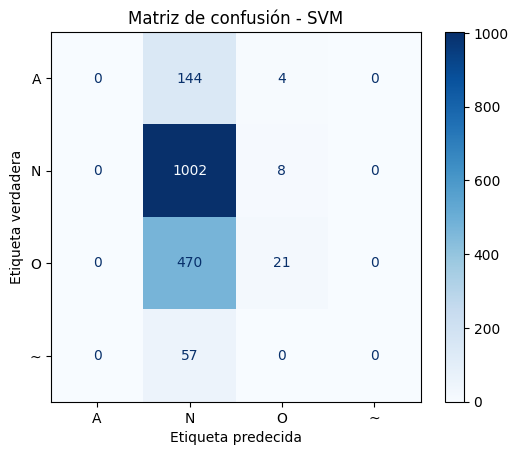

In [5]:
# Predecir sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM")
disp.ax_.set_xlabel('Etiqueta predecida')
disp.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


## 5. Conclusiones

- Dado que el modelo predice únicamente una etiqueta, debe haber un error en la fase de entrenamiento. Intentaré identificarlo y repararlo.
- UPDATE: Se detectó un problema en falta de estandarización de datos, la que fue agregada al procedimiento.
- UPDATE: Aún se detecta que no se detectan etiquetas 'A' ni '~', lo que sigue indicando un problema en la detección. Se probará modificando los parámetros en la detección de picos y otros modelos en la fase 3.

## 6. Trabajo para Informe Final

Este apartado es adicional sobre el trabajo de la semana 2 y se debe considerar como parte del trabajo para la entrega final.

### **Antes de examinar el código**

Es necesario destacar que para ejecutar el siguiente código, se debe antes ejecutar la primera celda de este cuadernillo, la que carga la mayoría de las librerías.

In [13]:
# El objetivo de esta sección es entrenar un modelo en base a un conjunto de datos usando solamente los datos correspondientes a etiquetas 'N' y 'A', para intentar maximizarla detección de arritmias.

# Cargar las características y las etiquetas
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Normlizar las características
scaler = StandardScaler()
features_df = features_df_orig.copy()
features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.fit_transform(
    features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Unir características y etiquetas
data = features_df.merge(labels_df, on='record').dropna()

# Filtrar los datos para usar solo las etiquetas 'N' y 'A'
data_filtered = data[data['label'].isin(['N', 'A'])]
# Separar variables (X) y etiquetas (y)
X_filtered = data_filtered[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y_filtered = data_filtered['label']

# Dividir en conjunto de entrenamiento y prueba
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)
# Entrenar un modelo base (SVM) con los datos filtrados
clf_filtered = SVC(kernel='rbf', random_state=42)
clf_filtered.fit(X_train_filtered, y_train_filtered)





SVC(random_state=42)

Métricas de desempeño del modelo SVM (solo N y A):
Accuracy:  0.8765
F1-Score:  0.8244
Precision: 0.8741
Recall:    0.8765

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.86      0.04      0.08       148
           N       0.88      1.00      0.93      1010

    accuracy                           0.88      1158
   macro avg       0.87      0.52      0.51      1158
weighted avg       0.87      0.88      0.82      1158



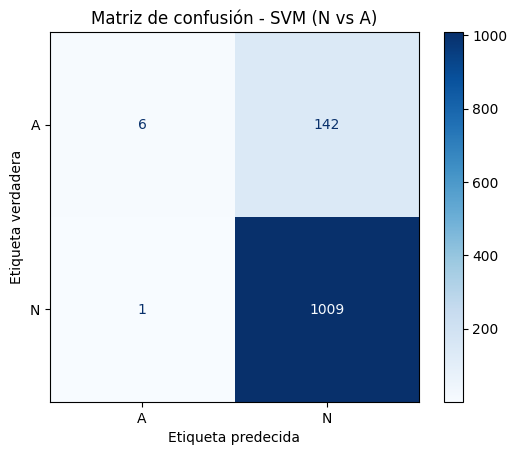

In [14]:
# Predecir sobre el conjunto de prueba filtrado y evaluar el modelo

# Predicción
y_pred_filtered = clf_filtered.predict(X_test_filtered)

# Calcular métricas de desempeño
accuracy_filtered = accuracy_score(y_test_filtered, y_pred_filtered)
f1_filtered = f1_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)
precision_filtered = precision_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)
recall_filtered = recall_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM (solo N y A):")
print(f"Accuracy:  {accuracy_filtered:.4f}")
print(f"F1-Score:  {f1_filtered:.4f}")
print(f"Precision: {precision_filtered:.4f}")
print(f"Recall:    {recall_filtered:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_filtered, y_pred_filtered, zero_division=0))

# Visualización de la matriz de confusión
disp_filtered = ConfusionMatrixDisplay.from_estimator(clf_filtered, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM (N vs A)")
disp_filtered.ax_.set_xlabel('Etiqueta predecida')
disp_filtered.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


# Guardar las características filtradas
data_filtered.to_csv('data/rr_features_filtered_n_a.csv', index=False)



In [15]:
from imblearn.over_sampling import SMOTE

# Preparar más datos de arritmia para combatir el desbalance de clases, usando la técnica de SMOTE (Synthetic Minority Over-sampling Technique).


# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# Verificar el nuevo balance de clases
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribución de clases después de SMOTE:
label
N    4040
A    4040
Name: count, dtype: int64


Métricas de desempeño del modelo SVM balanceado:
Accuracy:  0.7314
F1-Score:  0.7749
Precision: 0.8889
Recall:    0.7314

Reporte de clasificación del modelo balanceado:
              precision    recall  f1-score   support

           A       0.31      0.87      0.45       148
           N       0.97      0.71      0.82      1010

    accuracy                           0.73      1158
   macro avg       0.64      0.79      0.64      1158
weighted avg       0.89      0.73      0.77      1158



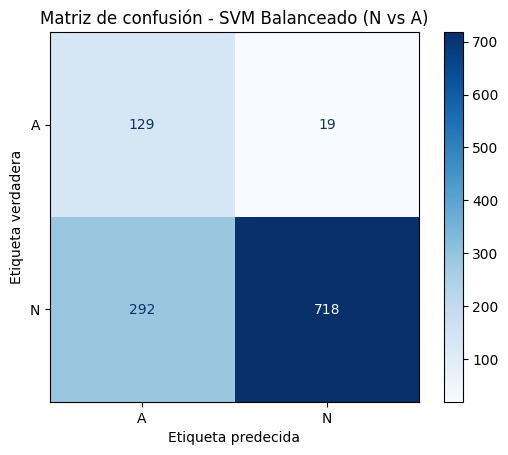

In [16]:
# Entrenar un nuevo modelo SVM con los datos balanceados
clf_balanced = SVC(kernel='rbf', random_state=42)
clf_balanced.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba con el modelo balanceado
y_pred_balanced = clf_balanced.predict(X_test_filtered)

# Calcular métricas de desempeño del modelo balanceado
accuracy_balanced = accuracy_score(y_test_filtered, y_pred_balanced)
print("Métricas de desempeño del modelo SVM balanceado:")
print(f"Accuracy:  {accuracy_balanced:.4f}")
f1_balanced = f1_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"F1-Score:  {f1_balanced:.4f}")
precision_balanced = precision_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"Precision: {precision_balanced:.4f}")
recall_balanced = recall_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"Recall:    {recall_balanced:.4f}")
print("\nReporte de clasificación del modelo balanceado:")
print(classification_report(y_test_filtered, y_pred_balanced, zero_division=0))

# Visualización de la matriz de confusión del modelo balanceado
disp_balanced = ConfusionMatrixDisplay.from_estimator(clf_balanced, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM Balanceado (N vs A)")
disp_balanced.ax_.set_xlabel('Etiqueta predecida')
disp_balanced.ax_.set_ylabel('Etiqueta verdadera')
plt.show()




Resumen de las predicciones para los datos 'O':
predicted_label
N    1313
A    1143
Name: count, dtype: int64


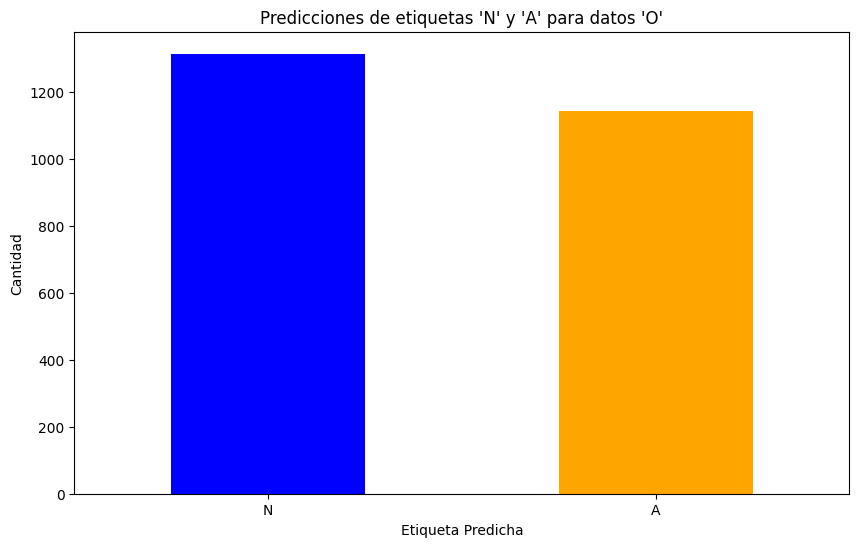

In [17]:
# Ahora, se engañará al modelo para que prediga sobre los datos 'O' como si fueran 'N' o 'A', para ver si el modelo puede detectar arritmias en los datos de referencia.

# Cargar las características y las etiquetas de los datos de referencia
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Filtrar los datos para usar solo las etiquetas 'O'
data_orig = features_df_orig.merge(labels_df, on='record').dropna()
data_o = data_orig[data_orig['label'] == 'O'].copy()

# Normalizar las características de los datos 'O'
data_o.loc[:, ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.transform(
    data_o[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Preparar los datos 'O' para la predicción
X_o = data_o[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]

# Predecir las etiquetas 'N' o 'A' para los datos 'O'
y_pred_o = clf_balanced.predict(X_o)

# Agregar las predicciones al DataFrame de datos 'O'
data_o['predicted_label'] = y_pred_o

# Guardar las predicciones de los datos 'O'
data_o.to_csv('data/rr_features_predicted_o.csv', index=False)

# Mostrar un resumen de las predicciones
print("\nResumen de las predicciones para los datos 'O':")
print(data_o['predicted_label'].value_counts())

# Visualizar las predicciones de los datos 'O'
plt.figure(figsize=(10, 6))
data_o['predicted_label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Predicciones de etiquetas 'N' y 'A' para datos 'O'")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.show()



Métricas de desempeño del modelo SVM con datos 'O' como 'N':
Accuracy:  0.8066
F1-Score:  0.8288
Precision: 0.8690
Recall:    0.8066

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.36      0.66      0.47       148
           N       0.94      0.83      0.88      1010

    accuracy                           0.81      1158
   macro avg       0.65      0.74      0.67      1158
weighted avg       0.87      0.81      0.83      1158



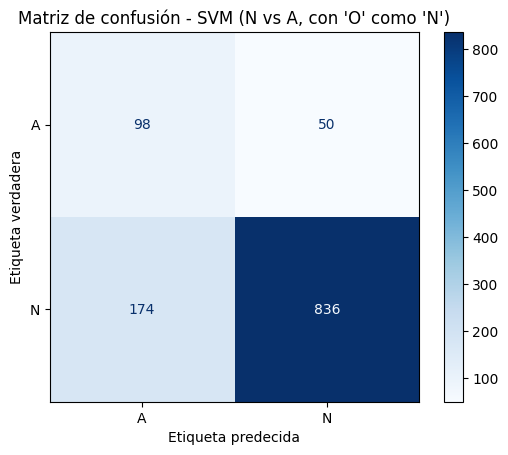

In [18]:
# El siguiente paso es entrenar el modelo con los datos 'O' como si fueran 'N' para intentar mejorar la precisión del modelo.

# Dividir data_o en entrenamiento y prueba
X_o_train, X_o_test = train_test_split(X_o, test_size=0.2, random_state=42, stratify=None)

# Crear etiquetas 'N' para los datos 'O'
y_o_train = pd.Series(['N'] * len(X_o_train), index=X_o_train.index)
y_o_test = pd.Series(['N'] * len(X_o_test), index=X_o_test.index)

# Unir los datos 'O' de entrenamiento a los datos balanceados originales
X_train_augmented = pd.concat([X_train_resampled, X_o_train], ignore_index=True)
y_train_augmented = pd.concat([y_train_resampled, y_o_train], ignore_index=True)


# Entrenar un nuevo modelo SVM con los datos aumentados
clf_augmented = SVC(kernel='rbf', random_state=42)
clf_augmented.fit(X_train_augmented, y_train_augmented)

# Predecir sobre el conjunto de prueba original (N vs A)
y_pred_augmented = clf_augmented.predict(X_test_filtered)

# Calcular métricas de desempeño
accuracy_augmented = accuracy_score(y_test_filtered, y_pred_augmented)
f1_augmented = f1_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)
precision_augmented = precision_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)
recall_augmented = recall_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM con datos 'O' como 'N':")
print(f"Accuracy:  {accuracy_augmented:.4f}")
print(f"F1-Score:  {f1_augmented:.4f}")
print(f"Precision: {precision_augmented:.4f}")
print(f"Recall:    {recall_augmented:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_filtered, y_pred_augmented, zero_division=0))

# Visualización de la matriz de confusión
disp_augmented = ConfusionMatrixDisplay.from_estimator(clf_augmented, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM (N vs A, con 'O' como 'N')")
disp_augmented.ax_.set_xlabel('Etiqueta predecida')
disp_augmented.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


Distribución de clases después de SMOTE en datos aumentados:
N    6004
A    6004
Name: count, dtype: int64
Métricas de desempeño del modelo SVM balanceado con datos 'O' como 'N':
Accuracy:  0.7271
F1-Score:  0.7711
Precision: 0.8821
Recall:    0.7271

Reporte de clasificación del modelo balanceado con datos 'O' como 'N':
              precision    recall  f1-score   support

           A       0.30      0.84      0.44       148
           N       0.97      0.71      0.82      1010

    accuracy                           0.73      1158
   macro avg       0.63      0.77      0.63      1158
weighted avg       0.88      0.73      0.77      1158



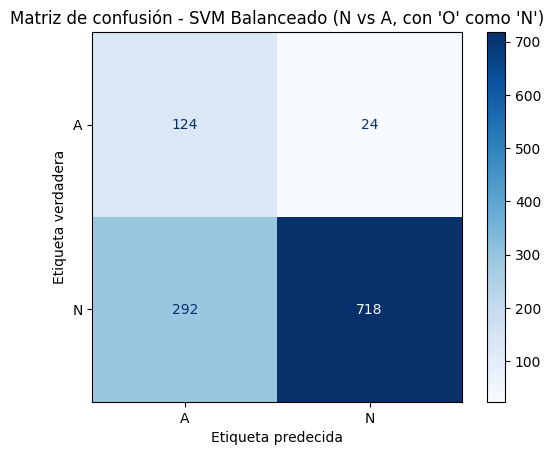

In [19]:
# Por último, se hará un nuevo rebalance de los datos aumentados y se reentrenará el modelo para ver si se mejora la precisión.

# Aplicar SMOTE a los datos aumentados
smote_augmented = SMOTE(random_state=42)
X_train_aug_resampled, y_train_aug_resampled = smote_augmented.fit_resample(X_train_augmented, y_train_augmented)

# Verificar el nuevo balance de clases
print("Distribución de clases después de SMOTE en datos aumentados:")
print(pd.Series(y_train_aug_resampled).value_counts())

# Reentrenar el modelo con los datos aumentados y balanceados
clf_augmented = SVC(kernel='rbf', random_state=42)
clf_augmented.fit(X_train_aug_resampled, y_train_aug_resampled)

# Predecir sobre el conjunto de prueba original (N vs A) con el modelo balanceado
y_pred_aug_resampled = clf_augmented.predict(X_test_filtered)

# Calcular métricas de desempeño del modelo balanceado
accuracy_aug_resampled = accuracy_score(y_test_filtered, y_pred_aug_resampled)
f1_aug_resampled = f1_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
precision_aug_resampled = precision_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
recall_aug_resampled = recall_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
print("Métricas de desempeño del modelo SVM balanceado con datos 'O' como 'N':")
print(f"Accuracy:  {accuracy_aug_resampled:.4f}")
print(f"F1-Score:  {f1_aug_resampled:.4f}")
print(f"Precision: {precision_aug_resampled:.4f}")
print(f"Recall:    {recall_aug_resampled:.4f}")
print("\nReporte de clasificación del modelo balanceado con datos 'O' como 'N':")
print(classification_report(y_test_filtered, y_pred_aug_resampled, zero_division=0))

# Visualización de la matriz de confusión del modelo balanceado con datos 'O' como 'N'
disp_aug_resampled = ConfusionMatrixDisplay.from_estimator(clf_augmented, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM Balanceado (N vs A, con 'O' como 'N')")
disp_aug_resampled.ax_.set_xlabel('Etiqueta predecida')
disp_aug_resampled.ax_.set_ylabel('Etiqueta verdadera')
plt.show()
